In [5]:
using SparseArrays
using JLD2
using FileIO
function mod_idx(idx,n)
    while idx < 1
        idx += n
    end
    while idx > n
        idx -= n
    end
    return idx
end

function diff_mat2d(nx,ny,along,odiff,oacc=4,load_from_file =false)
    """
    nx,ny : the number of points in each dimension
    along : derivative along x-axis(along=1) or y-axis(along=2)
    odiff : order of the derivative
    oacc  : order of accuracy
    load_from_file : try to load precaluclated matrices
    return: the difference matrix
    *note that the marix if for periodic boundary. 
    *TBD : we introduce ghost layers for other boundary conditions to save the labour of 
        modifying the difference matrices, and these layers should be reset after 
        each iteration in time
    """
    if load_from_file
        file_name = "diff_mat2d_nx$(nx)_ny$(ny)_along$(along)_odiff$(odiff)_oacc$(oacc).jld2"
        # @__FILE__ is the location for the current running file
        # dirname(LOC) get the parent directory of LOC
        directory = joinpath(dirname(dirname(@__FILE__)),"save_diff_mat")
        full_file_name = joinpath(directory,file_name)
        if isfile(full_file_name)
            diff_mat = JLD2.load(full_file_name,"diff_mat2d")
            return diff_mat
        end
    end
        
    N = nx*ny
    if oacc == 2
        cdiff_coeff = [0.0  -0.5  0.0   0.5   0.0;
                       0.0   1.0 -2.0   1.0   0.0]
    elseif oacc == 4
        cdiff_coeff = [1.0/12.0  -2.0/3.0  0.0      2.0/3.0  -1.0/12.0;
                      -1.0/12.0   4.0/3.0 -5.0/2.0 	4.0/3.0  -1.0/12.0]
    elseif oacc == 6
        cdiff_coeff = [-1.0/60.0  3.0/20.0  -3.0/4.0  0.0        3.0/4.0  -3.0/20.0  1.0/60.0;
                        1.0/90.0 -3.0/20.0 	 3.0/2.0 -49.0/18.0  3.0/2.0  -3.0/20.0  1.0/90.0]
    elseif oacc == 8
        cdiff_coeff = [1.0/280.0  -4.0/105.0  1.0/5.0  -4.0/5.0   0.0         4.0/5.0  -1.0/5.0  4.0/105.0  -1.0/280.0;
                      -1.0/560.0   8.0/315.0 -1.0/5.0   8.0/5.0  -205.0/72.0  8.0/5.0  -1.0/5.0  8.0/315.0  -1.0/560.0]
    else
        error("oacc = 2,4,6 or 8, no other values allowed")
    end
    nrow,ncol = size(cdiff_coeff)
    nbrs = ncol ÷ 2         # integer division
    diff_mat = spzeros(Float64, N, N)
    stencil_ind =  Array{Int64,1}(undef,ncol)

    #=
    # a special case for order of accuracy = 2
    for i in 1:nx
        for j in 1:ny   
            if along == 1 
                stencil_ind[3] = i + (j-1)*nx                  # center
                stencil_ind[2] = mod_idx(i - 1, nx) + (j-1)*nx # left one
                stencil_ind[1] = mod_idx(i - 2, nx) + (j-1)*nx # left two
                stencil_ind[4] = mod_idx(i + 1, nx) + (j-1)*nx # right one
                stencil_ind[5] = mod_idx(i + 2, nx) + (j-1)*nx # right two
            elseif along == 2
                stencil_ind[3] = i + (j-1)*nx                        # center
                stencil_ind[2] = i + (mod_idx(j - 1, ny) - 1)*nx     # upper one
                stencil_ind[1] = i + (mod_idx(j - 2, ny) - 1)*nx     # upper two
                stencil_ind[4] = i + (mod_idx(j + 1, ny) - 1)*nx     # lower one
                stencil_ind[5] = i + (mod_idx(j + 2, ny) - 1)*nx     # lower two
            else
                error("along = 1 or 2, no other values allowed")
            end
            for is in 1:5
                diff_mat[stencil_ind[3],stencil_ind[is]] = cdiff_coeff[odiff,is]
            end
        end
    end
    =#
    for i in 1:nx
        for j in 1:ny   
            if along == 1 
                stencil_ind[nbrs + 1] = i + (j-1)*nx                             # center
                for nl in 1:nbrs
                    stencil_ind[nbrs + 1 - nl] = mod_idx(i - nl, nx) + (j-1)*nx   # the point left to the center by nl unit
                end
                for nr in 1:nbrs
                    stencil_ind[nbrs + 1 + nr] = mod_idx(i + nr, nx) + (j-1)*nx  # right one
                end
            elseif along == 2
                stencil_ind[nbrs + 1] = i + (j-1)*nx                              # center
                for nu in 1:nbrs
                    stencil_ind[nbrs + 1 - nu] = i + (mod_idx(j - nu, ny) - 1)*nx  # the point up to the center by nu unit
                end
                for nd in 1:nbrs
                    stencil_ind[nbrs + 1 + nd] = i + (mod_idx(j + nd, ny) - 1)*nx # the point down to the center by nd unit
                end
            else
                error("along = 1 or 2, no other values allowed")
            end 
            for is in 1:ncol
                diff_mat[stencil_ind[nbrs + 1],stencil_ind[is]] = cdiff_coeff[odiff,is]
            end
        end
    end
    dropzeros!(diff_mat)
    if load_from_file
        # save the calculated matix for future use
        file_name = "diff_mat2d_nx_$(nx)_ny$(ny)_along$(along)_odiff$(odiff)_oacc$(oacc).jld2"
        # @__FILE__ is the location for the current running file
        # dirname(LOC) get the parent directory of LOC
        directory = joinpath(dirname(dirname(@__FILE__)),"save_diff_mat")
        full_file_name = joinpath(directory,file_name)
        if isdir(directory)
            FileIO.save(full_file_name,"diff_mat2d",diff_mat)
        else
            mkdir(directory)
            JLD2.save(full_file_name,"diff_mat2d",diff_mat)
        end
    end
    return sparse(diff_mat)
end

diff_mat2d (generic function with 3 methods)

In [11]:
# Test the difference matrices
# include("./src/finite_diff.jl")
using Printf
# pbc f(0,y) = f(x_max,y),f(x,0) = f(x,y_max)
# descritization: delta_x = x_max/nx, delta_y = y_max/ny
# descretised field f[1 2... nx, 1 2... ny] 
# pbc: f[0,...] = f[nx,...] and f[...,0]=f[...,ny]
# f[0,...] and f[... ,0] are not included in the lattice 

x_max = y_max = 2.0*pi
nx = 64
ny = 64
N = nx*ny
delta_x = x_max/nx
delta_y = y_max/ny

x = range(delta_x, stop=2*pi, length=nx)
y = transpose(range(delta_y, stop=2*pi, length=ny))
f = @. sin(x)*cos(2.0*y)

# 0th order derivative
exact_derivatives = Dict((0,0)=>f)
# first derivatives(exact)
exact_derivatives[(1,0)] = @. cos(x)*cos(2.0*y)      #df/dx
exact_derivatives[(0,1)] = @. -2.0*sin(x)*sin(2.0*y) # dy/dx
# second derivatives(exact)
exact_derivatives[(2,0)] = @. -sin(x)*cos(2.0*y)     #d2f/dx2
exact_derivatives[(0,2)] = @. -4.0*sin(x)*cos(2.0*y) #d2d/dy2
exact_derivatives[(1,1)] = @. -2.0*cos(x)*sin(2.0*y) #d2/dxdy
# third derivatives(exact)
exact_derivatives[(3,0)] = @. -cos(x)*cos(2.0*y)     #d3f/dx3
exact_derivatives[(2,1)] = @. 2.0*sin(x)*sin(2.0*y) #d/dy d2f/dx2 
exact_derivatives[(1,2)] = @. -4.0*cos(x)*cos(2.0*y) #d/dx d2f/dy2 
exact_derivatives[(0,3)] = @. 8.0*sin(x)*sin(2.0*y)  #d3f/dy3 
# fourth derivatives(exact)
exact_derivatives[(4,0)] = @. sin(x)*cos(2.0*y)       #d4f/dx4
exact_derivatives[(3,1)] = @. 2.0*cos(x)*sin(2.0*y)   #d/dy d3f/dx3 
exact_derivatives[(2,2)] = @. 4.0*sin(x)*cos(2.0*y)   #d^2/dx^2 d2f/dy2 
exact_derivatives[(1,3)] = @. 8.0*cos(x)*sin(2.0*y)  #d^4f/dy4
exact_derivatives[(0,4)] = @. 16.0*sin(x)*cos(2.0*y)  #d^4f/dy4
oacc = 4
println(size(exact_derivatives[(0,4)]))
for odx in 0:2
    for ody in 0:2
        if odx + ody <= 4 && odx + ody > 0
            if odx == 0
                Dx = 1.0
            else
                Dx = diff_mat2d(nx,ny,1,odx,oacc)/(delta_x^odx)
            end
            if ody == 0
                Dy = 1.0
            else
                Dy = diff_mat2d(nx,ny,2,ody,oacc)/(delta_y^ody)
            end
            cdiff = Dx*Dy*reshape(f,(N,1))
            cdiff = reshape(cdiff,(nx,ny))
            rmse = sqrt(1.0/N*sum((cdiff - exact_derivatives[(odx,ody)]).^2))
            @printf("RMSE for [d/dx]^%i [d/dy]^%i is %1.8f \n",odx,ody,rmse)
        end
    end
end


(64, 64)
RMSE for [d/dx]^0 [d/dy]^1 is 0.00004932 
RMSE for [d/dx]^0 [d/dy]^2 is 0.00003292 
RMSE for [d/dx]^1 [d/dy]^0 is 0.00000155 
RMSE for [d/dx]^1 [d/dy]^1 is 0.00005241 
RMSE for [d/dx]^1 [d/dy]^2 is 0.00003910 
RMSE for [d/dx]^2 [d/dy]^0 is 0.00000052 
RMSE for [d/dx]^2 [d/dy]^1 is 0.00005035 
RMSE for [d/dx]^2 [d/dy]^2 is 0.00003498 


In [23]:
# Test the numerical integration using Simpson's rule
include("./src/finite_diff.jl")
using Printf
x = collect(range(0.0,1.0;length=20))
y = 4.0*x.^3
s = simpson_int1d(y,(0.0,1.0))
@printf("int 4x^3 from 0 to 1 is %1.8f, error is %1.8f\n",s,abs(1.0-s))

x  = collect(range(0.0,1.0*pi;length=20))
y = sin.(x)
s = simpson_int1d(y,(0.0,1.0*pi))
@printf("int sin(x) from 0 to pi is %1.8f, error is %1.8f\n",s,abs(2.0-s))

N = 100
x = collect(range(-4.0,4.0;length=N))
y = collect(range(-4.0,4.0;length=N))
z = exp.(-x.*x .- y'.*y').*(x.^2 .+ y.^2')'.*(x.^2 .+ y.^2')
@printf(" %1.8f\n",sum(z)*64/(N*N))

s = simpson_int2d(z,(-4.0,4.0),(-4.0,4.0))
@printf("int exp(-(x^2+y^2))*(x^2+y^2) in [-4,4]*[-6,6] %1.8f, error is %1.8f\n",s,abs(pi-s))




int 4x^3 from 0 to 1 is 0.93536217, error is 0.06463783
int sin(x) from 0 to pi is 1.99544132, error is 0.00455868
 3.07907265
int exp(-(x^2+y^2))*(x^2+y^2) in [-4,4]*[-6,6] 3.14158892, error is 0.00000374


In [120]:
# test the correlation integral
include("./src/finite_diff.jl")
Nw = 30
rx = collect(range(-5.0,5.0;length=2*Nw+1))
ry = collect(range(-5.0,5.0;length=2*Nw+1))
k = exp.(-rx.^2 .- (ry.^2)')

dx = 10.0/(2*Nw)
dy = 10.0/(2*Nw)

xx = collect(dx:dx:20.0)
yy = collect(dy:dy:20.0)
g = (10 .- xx).^2 .+ ((10 .- yy).^2)'

# the index of point (10,10)
cx,cy = trunc(Int,10/dx),trunc(Int,10/dy)+1
println(k[Nw+1,Nw+1])
s = corr2d(k,g,(cx,cy),dx,dy)
i = exp.(-g).*g 

#@printf("%1.8f\n",sum(i)*dx*dy)

#@printf("%1.8f\n",simpson_int2d(i,(0.0,20),(0.0,20)))
# the correlation integral is int dxdy exp((10-x)^2+(10-y)^2))*((10-x)^2+(10-y)^2)
@printf("int dxdy exp((10-x)^2+(10-y)^2))*((10-x)^2+(10-y)^2) %1.8f, error is %1.8f\n",s,abs(pi-s))



1.0
int exp(-(0-y^2))y^2  3.14159265, error is 0.00000000


In [17]:
# test the mean field model
include("./src/mean_field_model_gradient.jl")
using Printf
x_max = y_max = 2.0*pi
nx = ny = 256
N = nx*ny
T = 0.1
A = 0.1
B = 0.01
C = 0.01
K = 0.01
Gamma = 1.0
dt = 0.01

model = NumericalMeanField2D(x_max, y_max, nx, ny, dt)


set_model_params(model, T, A, B, C, K)
x = model.x
y = model.y'
rho = @. sin(x) * cos(2.0 * y)
rho_dx = @. cos(x) * cos(2.0 * y)
rho_dy = @. -2.0 * sin(x) * sin(2.0 * y)

rho_dxy = @. -2.0 * cos(x) * sin(2.0 * y)
rho_dxx = @. -sin(x) * cos(2.0 * y)
rho_dyy = @. -4.0 * sin(x) * cos(2.0 * y)
mu = @. 2.0*A * rho + 3.0*B * rho^ 2 - 2.0*K * (-5.0 * sin(x) * cos(2.0 * y))

j = zeros(Float64, 2, nx, ny)
j[1, :, :] = @. rho * (2.0*A * rho_dx + 6.0 * B * rho * rho_dx - 2.0*K * (-5.0 * cos(x) * cos(2.0 * y))) + T*rho_dx
j[2, :, :] = @. rho * (2.0*A * rho_dy + 6.0 * B * rho * rho_dy - 2.0*K * (10.0 * sin(x) * sin(2.0 * y))) + T*rho_dy
f = zeros(Float64, 2, nx, ny)

#sigma_xx = @. -C*(sin(x) * cos(2.0 * y))^2
#sigma_xy = @. -C*0.5 * sin(2.0 * x) * sin(4.0 * yprintln(rho))
#sigma_yy = @. -C*4.0 * (sin(x) * cos(2.0 * y))^2

f = zeros(Float64, 2, nx, ny)
f[1, :, :] = @. 2.0*C*(-sin(2.0 * x) * (cos(2.0 * y)^2) - 2.0 * sin(2.0 * x) * cos(4.0 * y))
f[2, :, :] = @. 2.0*C*(-cos(2.0 * x)* sin(4.0 * y) + 8.0 * sin(x)^2 * sin(4.0 * y))

set_initial_condition(model,rho)
update_parallel!(model)
rho_fd = reshape(model.rho,nx,ny)
rmse = sqrt(1.0/N*sum((rho_fd - rho).^2))
@printf("RMSE for rho is %1.8f \n",rmse)

# rmse of mu
mu_fd = reshape(model.mu,nx,ny)
rmse_mu = sum(abs.(mu_fd - mu))/sum(abs.(mu))
@printf("RMSE for mu is %1.8f \n",rmse_mu)
println(mu_fd[10,10])
println(mu[10,10])

# rmse of j
for alpha in 1:2
    j_fd = reshape(model.j[alpha, :, :],(nx,ny))
    rmse_j = sum(abs.(j_fd - j[alpha, :, :]))/sum(abs.(j[alpha, :, :]))
    @printf("RMSE for the %i th component of flux, j, is %1.8f \n",alpha,rmse_j)
end

# rmse of f
for alpha in 1:2
    f_fd = reshape(model.f[alpha, :, :],(nx,ny))
    rmse_f = sum(abs.(f_fd - f[alpha, :, :]))/sum(abs.(f[alpha, :, :]))
    @printf("RMSE for the %i th component of force density, f, is %1.8f \n",alpha,rmse_f)
end


LoadError: LoadError: invalid redefinition of constant NumericalMeanField2D
in expression starting at /Users/satyamanand/Desktop/Bromf-main/src/mean_field_model_gradient.jl:12

In [812]:
include("./src/mean_field_model_integral.jl")
using Printf
x_max = y_max = 60.0
nx = ny = 256
N = nx*ny
T = 1.0
R = 0.0
D = 0.0
Gamma = 1.0
dt = 0.005
# the analtical solution for 2d difustion euqation with Gaussian initial condition
# dt u = D*(dxx u + dyy u)
# rho(x,y) = 1/t*exp(-(x-x0)^2-(y-y0)^2/(4D*t))
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "julia-Tsit5")
x = model.x 
y = model.y'
t0 = 1.0
rho_0 =  @. 1.0/t0*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*t0))
set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
nsteps = [1,10,100,200,500,1000]
for nstep in nsteps
    t = dt*nstep
    rho_t = @. 1.0/(t+t0)*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*(t+t0)))
    set_initial_condition(model,rho_0)
    #for i in 1:nstep
    #    one_step(model)
    #end
    n_steps(model,nstep)
    rho_fd = reshape(model.rho,nx,ny)
    rmse = sum(abs.(rho_fd-rho_t))/sum(abs.(rho_t))
    @printf("RMSE for the t=%1.6f of density, rho, is %1.8f \n",t,rmse)
    print(amin)
end



LoadError: LoadError: invalid redefinition of constant NumericalMeanField2D
in expression starting at /Users/satyamanand/Desktop/Bromf-main/src/mean_field_model_integral.jl:12

In [409]:
include("./src/only_noise_term.jl")
using Printf
using Statistics
using Plots
x_max = y_max = 60.0
nx = ny = 32  #256
N = nx*ny
T = 0.0
R = 1.0  #5.0
D = 0.01  #0.01
Gamma = 1.0
dt = 0.005
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
x = model.x 
y = model.y'
t0 = 1.0
# rho_0 = fill(0.01, (nx, ny))
a = 0.01  #1
b = 0.02  #2
rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))


set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
nsteps = [100]


for nstep in nsteps
    t = dt*nstep
    # rho_t = @. 1.0/(t+t0)*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*(t+t0)))
    set_initial_condition(model,rho_0)
    for i in 1:nstep
        one_step(model)
    end
    # n_steps(model,nstep)
    # rho_fd = reshape(model.rho,nx,ny)
    # @printf("rho at time t=%1.6f, rho, is %1.8f \n",t,maximum(rho_fd))
end
kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
k,s = get_radial_structure_factor(kx,ky,s_2d)
rho_final = reshape(model.rho,nx,ny)



LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.00015034214692276684:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[90mBase.Math[39m [90m./[39m[90;4mmath.jl:33[0m
      [2] [0m[1msqrt[22m
    [90m    @ [39m[90m./[39m[90;4mmath.jl:582[0m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m[90m [inlined][39m
      [5] [0m[1m_getindex[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:644[0m[90m [inlined][39m
      [6] [0m[1m_broadcast_getindex[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:620[0m[90m [inlined][39m
      [7] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m[90m [inlined][39m
      [8] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:984[0m[90m [inlined][39m
      [9] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90;4msimdloop.jl:77[0m[90m [inlined][39m
     [10] [0m[1mcopyto![22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:983[0m[90m [inlined][39m
     [11] [0m[1mcopyto![22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:936[0m[90m [inlined][39m
     [12] [0m[1mcopy[22m
    [90m    @ [39m[90m./[39m[90;4mbroadcast.jl:908[0m[90m [inlined][39m
     [13] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{2}, Nothing, typeof(*), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{2}, Nothing, typeof(sqrt), Tuple{Matrix{Float64}}}, Matrix{Float64}}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase.Broadcast[39m [90m./[39m[90;4mbroadcast.jl:883[0m
     [14] [0m[1mupdate_noise_parallel![22m[0m[1m([22m[90mmodel[39m::[0mNumericalMeanField2D, [90mnpts_per_th[39m::[0mInt64, [90mth_num[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m~/Desktop/Bromf-main/src/[39m[90;4monly_noise_term.jl:268[0m
     [15] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/Desktop/Bromf-main/src/[39m[90;4monly_noise_term.jl:383[0m[90m [inlined][39m
     [16] [0m[1m(::var"#9655#threadsfor_fun#472"{NumericalMeanField2D, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [17] [0m[1m(::var"#9655#threadsfor_fun#472"{NumericalMeanField2D, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

In [378]:
include("./src/only_noise_term.jl")
# include("./src/mean_field_model_integral.jl")
include("./src/utils.jl")

using Printf
using Statistics
using Plots
x_max = y_max = 60.0
nx = ny = 32  #256
N = nx*ny
T = 0.0
R = 1.0  #1.0
D = 0.1  #0.01
Gamma = 1.0
dt = 0.005
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
# model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "julia-Tsit5")
x = model.x 
y = model.y'
t0 = 1.0
# rho_0 = fill(0.01, (nx, ny))
a = 1 #0.1
b = 2 #0.2
# rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))

set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
nsteps = ones(Float64,1000)

kx_list = []
ky_list = []
s_2d_list = []
k_list = []
s_list = []
rho_final_list = []
rho_var_list = []
rho_mean_list = []

drho_list = []

# for j in 1:1000

    # set_initial_condition(model,rho_0)

for nstep in nsteps
    # t = dt*nstep
    # rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))
    # set_initial_condition(model,rho_0)

    model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
    x = model.x 
    y = model.y'
    t0 = 1.0
    a = 1
    b = 2
    set_model_params(model,T,D,R,Gamma)
    set_initial_condition(model,rho_0)

    for i in 1:nstep

        # kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
        # k,s = get_radial_structure_factor(kx,ky,s_2d)
        # rho_final = reshape(model.rho,nx,ny)    

        # push!(kx_list,kx)
        # push!(ky_list,ky)
        # push!(s_2d_list,s_2d)
        # push!(k_list,k)
        # push!(s_list,s)
        # push!(rho_final_list,rho_final)
        # push!(rho_var_list,var(model.rho))
        # push!(rho_mean_list,mean(model.rho))

        push!(drho_list,reshape(model.drho,nx,ny))
        
        one_step(model)
        # n_steps(model,1)
    end
    # n_steps(model,nstep)
    # @printf("rho at time t=%1.6f, rho, is %1.8f \n",t,maximum(rho_fd))
end
# end
# kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
# k,s = get_radial_structure_factor(kx,ky,s_2d)
# rho_final = reshape(model.rho,nx,ny)   

In [ ]:
include("./src/only_noise_term.jl")
# include("./src/mean_field_model_integral.jl")
include("./src/utils.jl")

using Printf
using Statistics
using Plots
x_max = y_max = 60.0
nx = ny = 32  #256
N = nx*ny
T = 0.0
R = 1.0  #1.0
D = 0.1  #0.01
Gamma = 1.0
dt = 0.005
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
# model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "julia-Tsit5")
x = model.x 
y = model.y'
t0 = 1.0
# rho_0 = fill(0.01, (nx, ny))
a = 1 #0.1
b = 2 #0.2
# rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))

set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
nsteps = ones(Float64,1000)

kx_list = []
ky_list = []
s_2d_list = []
k_list = []
s_list = []
rho_final_list = []
rho_var_list = []
rho_mean_list = []

drho_list = []

# for j in 1:1000

    # set_initial_condition(model,rho_0)

for nstep in nsteps
    # t = dt*nstep
    # rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))
    # set_initial_condition(model,rho_0)

    model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
    x = model.x 
    y = model.y'
    t0 = 1.0
    a = 1
    b = 2
    set_model_params(model,T,D,R,Gamma)
    set_initial_condition(model,rho_0)

    for i in 1:nstep

        # kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
        # k,s = get_radial_structure_factor(kx,ky,s_2d)
        # rho_final = reshape(model.rho,nx,ny)    

        # push!(kx_list,kx)
        # push!(ky_list,ky)
        # push!(s_2d_list,s_2d)
        # push!(k_list,k)
        # push!(s_list,s)
        # push!(rho_final_list,rho_final)
        # push!(rho_var_list,var(model.rho))
        # push!(rho_mean_list,mean(model.rho))

        push!(drho_list,reshape(model.drho,nx,ny))
        
        one_step(model)
        # n_steps(model,1)
    end
    # n_steps(model,nstep)
    # @printf("rho at time t=%1.6f, rho, is %1.8f \n",t,maximum(rho_fd))
end
# end
# kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
# k,s = get_radial_structure_factor(kx,ky,s_2d)
# rho_final = reshape(model.rho,nx,ny)   

In [402]:
a = 1
b = 2
rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))

32×32 Matrix{Float64}:
 1.19879  1.83102  1.2164   1.79905  …  1.24322  1.97031  1.70066  1.07429
 1.03141  1.3329   1.35215  1.17737     1.4338   1.77658  1.70077  1.86824
 1.80397  1.67086  1.90822  1.00908     1.02541  1.29231  1.37733  1.25671
 1.3301   1.19873  1.88015  1.32096     1.38005  1.30754  1.58223  1.09791
 1.88473  1.17485  1.32709  1.97836     1.18348  1.58138  1.03151  1.17382
 1.95035  1.47427  1.92142  1.22362  …  1.84448  1.48609  1.53934  1.73508
 1.55931  1.42577  1.89828  1.47139     1.01999  1.8677   1.00127  1.17858
 1.91298  1.95559  1.18104  1.53781     1.62853  1.55954  1.37939  1.85302
 1.33364  1.07643  1.93853  1.38493     1.47329  1.83367  1.06011  1.79243
 1.55468  1.33632  1.05896  1.10531     1.18382  1.08866  1.76431  1.0977
 1.7366   1.94227  1.25777  1.51671  …  1.02359  1.06627  1.20284  1.05433
 1.67649  1.05515  1.80293  1.94728     1.82062  1.50556  1.58807  1.46822
 1.84554  1.14485  1.20998  1.15593     1.57651  1.54296  1.51727  1.91473
 ⋮ 

In [406]:
th_num = 1
npts = [nx, ny]
num_th = 1
npts_per_th = div(npts[1] * npts[2],num_th)

model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
x = model.x 
y = model.y'
t0 = 1.0

set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)

drho = zeros(Float64, nx * ny)
drho_list = []

for j in 1:1000

    idx_rng = npts_per_th*(th_num-1)+1:npts_per_th*th_num

    # calculate the force in noise term
    rho = reshape(model.rho,(model.npts[1],model.npts[2]))
    for alpha in 1:2
        # sample a matrix of model.npts[1]*model.npts[2] Gaussian random variables with mean = 0 and sd = sqrt(dt)
        model.white_noise = randn(model.npts[1]*model.npts[2])
        #make sd = 1 instead of sert(dt) for testing
        white_noise = reshape(model.white_noise, (model.npts[1],model.npts[2]))

        model.color_noise[(alpha,)] = sqrt.(rho).*white_noise
        for beta in 1:2
            for idx in idx_rng
                # the noise stress at (ix*dx,iy*dy)
                ix = mod_idx(idx,model.npts[1]) 
                iy = div(idx - ix,model.npts[1]) + 1
                model.force_noise[alpha, idx] +=  sqrt(model.params["D"])*model.rho[idx]*corr2d(
                    model.noise_kernel[(alpha,beta)],model.color_noise[(alpha,)],(ix,iy),model.delta[1],model.delta[2])
            end
        end
    end

    # calculate the noise part ∇.force_noise
    for alpha in 1:2
        
        model.drho[idx_rng] .= 0.0
        odiff = [0, 0]
        odiff[alpha] = 1

        #for testing
        model.drho[idx_rng] += (model.block_cdiff_mat[tuple(odiff...)][th_num] * model.force_noise[alpha, :])

    end
    push!(drho_list,reshape(model.drho,nx,ny))
end


In [403]:
th_num = 1
npts = [nx, ny]
num_th = 1
npts_per_th = div(npts[1] * npts[2],num_th)

model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
x = model.x 
y = model.y'
t0 = 1.0

set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)

drho_list = []

for alpha in 1:2
    idx_rng = npts_per_th*(th_num-1)+1:npts_per_th*th_num
    model.drho[idx_rng] .= 0.0

    odiff = [0, 0]

    #calculate (grad density)^2
    odiff[alpha] = 1
    model.drho[idx_rng] += (model.block_cdiff_mat[tuple(odiff...)][th_num] * model.rho)
end
push!(drho_list,reshape(model.drho,nx,ny))


1-element Vector{Any}:
 [0.20179390528999896 0.004698062665597913 … -0.2389390611337474 -0.1338341166405848; -0.14275544299246606 0.08552963712279826 … 0.024440958759413767 -0.1784953269671296; … ; -0.22089650440991476 -0.009631469202632803 … 0.14540712763471664 0.1851689474875502; 0.02425644167371327 -0.10636959053353318 … 0.06111190367701658 0.173580128742504]

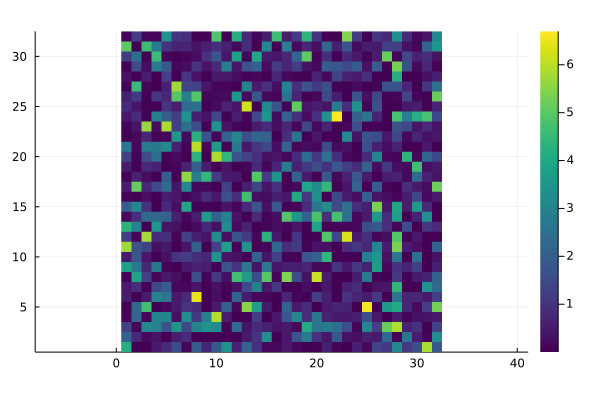

In [404]:
heatmap(drho_list[1].*drho_list[1]*D*N, color=:viridis, aspect_ratio=:equal) 

In [401]:
drho_list[1].*drho_list[1]*D*N

32×32 Matrix{Float64}:
 0.0206462   2.29222     0.756352     …  0.038575    2.39938     0.945164
 0.510317    0.894523    4.41455         0.015508    0.018407    2.26331
 0.0426719   0.0130138   0.143597        0.534008    0.622946    0.124169
 3.1483      0.321124    0.135581        0.0396323   0.692584    0.0467931
 0.717354    0.00464437  1.03777         1.05302     0.00361008  0.834434
 0.083052    1.55938     0.310241     …  3.05821     0.828112    0.224508
 1.39831     0.921448    0.00574445      3.30617     4.62661     0.0769031
 2.54427     1.79522     5.2903          1.95847     0.510997    4.56757
 0.724057    1.41534     0.0230465       1.3555      5.5957      0.00955015
 2.80003     3.76836     0.687604        0.248589    1.45879     0.923962
 3.31284     0.00366491  0.000556904  …  0.173247    0.0010554   1.95164
 0.329574    0.0187031   1.19865         4.09963     5.62876     5.00968
 0.0567677   1.89357     0.0179276       3.0229      0.14884     2.82678
 ⋮              

In [407]:
drho_mean = zeros(Float64,nx,ny)
for i in 1:1000
    drho_mean =( drho_list[i].*drho_list[i]) .+ drho_mean
end
drho_mean = drho_mean./1000.0

32×32 Matrix{Float64}:
    8.46121   406.468     926.441   …   2393.56      919.36      802.403
  293.476      13.46     2466.71         713.666      30.4385    435.565
 1388.31      218.406     266.192        689.52      160.493     213.307
 1143.34        2.45337  1231.35         669.385     654.429     498.21
  160.108     312.998    1302.69        1637.63      879.255      41.7394
   86.3649   5420.53     1075.15    …    299.802      36.7572   1369.16
    2.36147  5439.77     7624.81         258.83     1045.91      371.0
 4553.76     6388.05      132.5          263.186     700.089    2456.73
  519.402    7451.53     4905.58          22.0432   2097.54      546.658
  536.295     638.669    1810.67         136.107      38.0234     20.4369
   42.7972    483.03      397.58    …    212.254     285.556     197.364
 2009.47       31.3007     91.3302       334.475    4698.55      259.838
   18.4031    602.248      82.1545      4259.85      130.016     317.936
    ⋮                          

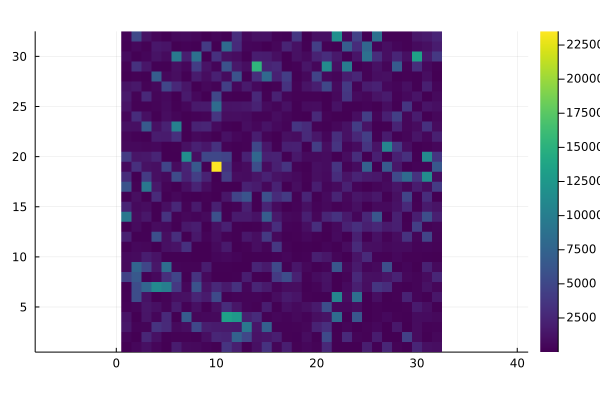

In [408]:
heatmap(drho_mean, color=:viridis, aspect_ratio=:equal) 

In [397]:
xx = drho_mean

32×32 Matrix{Float64}:
  4.50192      0.0765536   …   0.0132368    6.55853     1.1234
  1.58878      4.16592         8.6173       0.563554    0.0571391
  5.09939e-6   0.496432        1.41963      9.9287      1.44763
  0.25037      1.45992         0.179614     0.171798    2.73142
  0.750263     7.97585        41.2588       0.604659   25.3468
 13.4387       0.00123767  …   0.107836    24.9088      0.983002
  7.24115     17.6845          1.86946      0.995604    0.393881
 14.7176       8.73433         2.47325      0.0222041   3.8544
  0.297789     7.29742         6.05036      0.560358    0.136417
  5.12959      0.112487        1.08552      1.43633     0.911894
  0.653374    22.7077      …  48.6502       5.98719    12.8262
  0.199502     6.4892         26.6208      23.7962      6.32386
 17.6825      23.3137         39.0381       6.33933    31.4657
  ⋮                        ⋱                ⋮          
  4.69138      1.24382     …   0.0333086    8.84772     1.9926
  4.64108      0.548283  

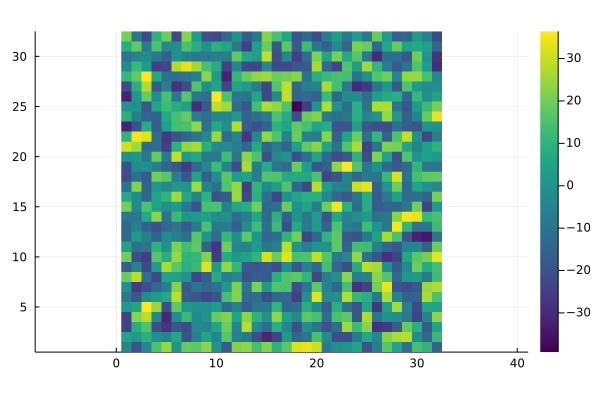

In [170]:
heatmap(reshape(drho_list[1],nx,ny), color=:viridis, aspect_ratio=:equal) 

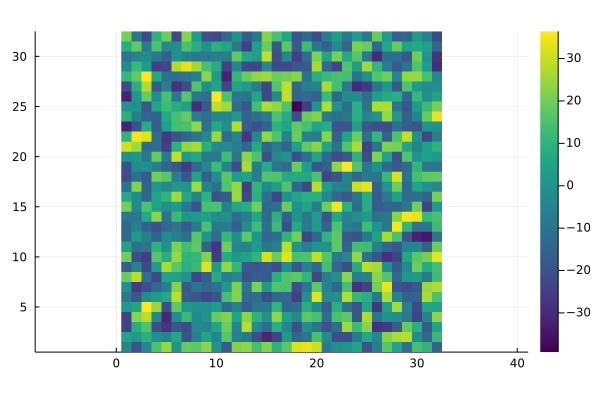

In [169]:
heatmap(reshape(drho_list[10],nx,ny), color=:viridis, aspect_ratio=:equal)

In [269]:
temp

1024-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [55]:
p2 = heatmap(kx,ky,log10.(s_2d)',aspect_ratio=:equal,tellheight=true,interpolate=true,title="log10 S(kx,ky)")
xlims!(p2,kx[1],kx[end])
ylims!(p2,kx[1],ky[end])

LoadError: UndefVarError: s_2d not defined

In [28]:
heatmap(reshape(rho_final,nx,ny), color=:viridis, aspect_ratio=:equal)


LoadError: UndefVarError: rho_final not defined

In [25]:
p3 = plot(k,s, marker='o', xscale=:log10, yscale=:log10,title="S(k)")

LoadError: UndefVarError: k not defined

┌ Warning: Skipped marker arg o.
└ @ Plots /Users/satyamanand/.julia/packages/Plots/Di0Qb/src/args.jl:1189


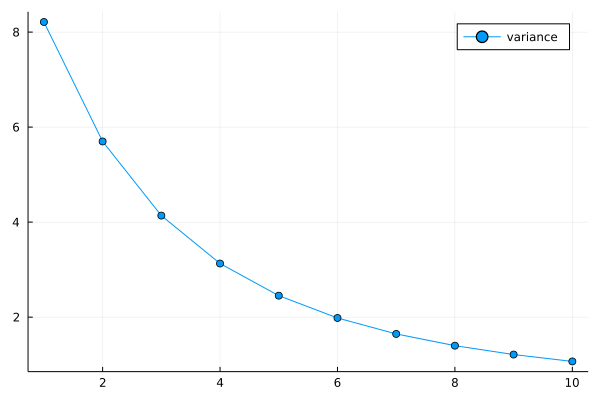

In [150]:
plot(rho_var_list, marker='o', label="variance")


In [151]:
size(s_list)

(10,)

┌ Warning: Skipped marker arg o.
└ @ Plots /Users/satyamanand/.julia/packages/Plots/Di0Qb/src/args.jl:1189


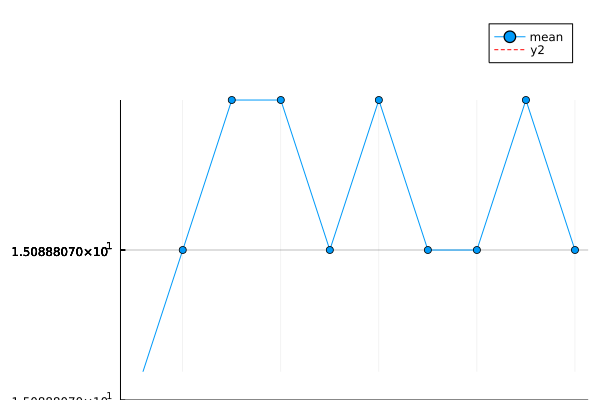

In [152]:
plot(rho_mean_list, marker='o', label="Mean")
hline!([mean(rho_0)], line=:dash, color=:red)


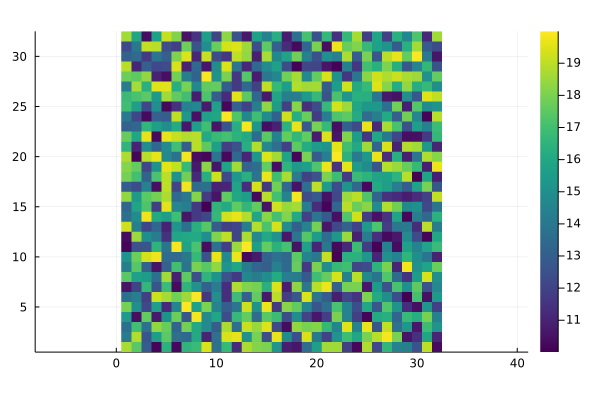

In [153]:
heatmap(reshape(rho_final_list[1],nx,ny), color=:viridis, aspect_ratio=:equal) 
# clims=(0.01, 0.02))

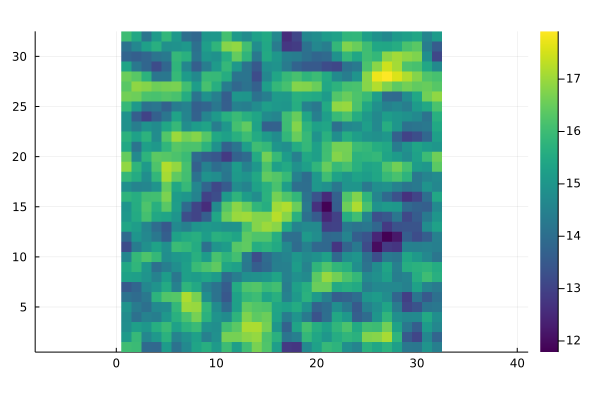

In [154]:
heatmap(reshape(rho_final_list[10],nx,ny), color=:viridis, aspect_ratio=:equal)
# , clims=(1, 2))



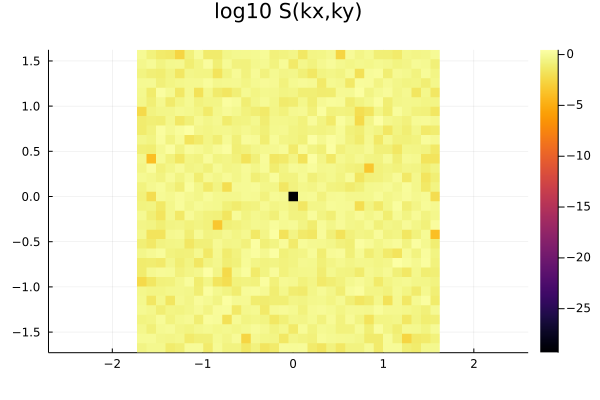

In [172]:
time = 1
p2 = heatmap(kx_list[time],ky_list[time],log10.(s_2d_list[time])',aspect_ratio=:equal,tellheight=true,interpolate=true,title="log10 S(kx,ky)")
# xlims!(p2,kx_list[1][1],kx_list[end][1])
# ylims!(p2,kx_list[1][1],ky_list[end][1])

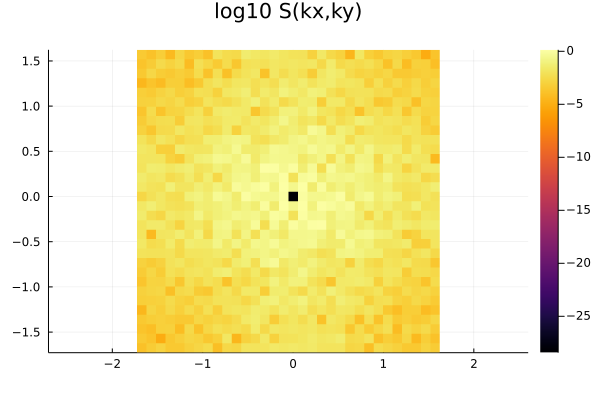

In [156]:
time = 10
p2 = heatmap(kx_list[time],ky_list[time],log10.(s_2d_list[time])',aspect_ratio=:equal,tellheight=true,interpolate=true,title="log10 S(kx,ky)")
# xlims!(p2,kx_list[1][1],kx_list[end][1])
# ylims!(p2,kx_list[1][1],ky_list[end][1])

In [560]:
using GLM
using DataFrames
using StatsBase

# Sample data
x = log10.(k_list[500][6:20])
y = log10.(s_list[500][6:20])

# Fit a straight line to the data
model = lm(@formula(y ~ x), DataFrame(x=x, y=y))

# # Access the coefficients and other statistics
# slope = coef(model)[2]
# intercept = coef(model)[1]

# # Print the slope and intercept of the line
# println("Slope: ", slope)
# println("Intercept: ", intercept)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.788944   0.0321328  -24.55    <1e-11  -0.858363  -0.719525
x             1.95135    0.112268    17.38    <1e-09   1.70881    2.1939
──────────────────────────────────────────────────────────────────────────

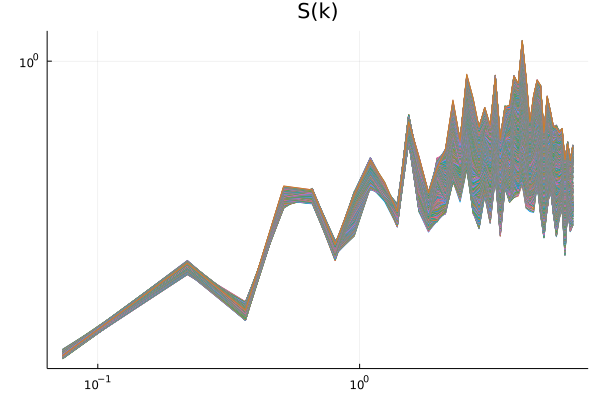

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/satyamanand/.julia/packages/PlotUtils/2GoqU/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/satyamanand/.julia/packages/PlotUtils/2GoqU/src/ticks.jl:295


In [108]:
p3 = plot(k_list[1:1000],s_list[1:1000], marker='o', xscale=:log10, yscale=:log10,title="S(k)", legend=false)


In [488]:
include("./src/only_noise_term.jl")
using Printf
using Statistics
using Plots
x_max = y_max = 60.0
nx = ny = 64  #256
N = nx*ny
T = 0.0
R = 1.0  #5.0
D = 0.0  #0.01
Gamma = 1.0
dt = 0.005
model = NumericalMeanField2D(x_max, y_max, nx, ny, dt, "forward-Euler")
x = model.x 
y = model.y'
t0 = 1.0
rho_0 = fill(0.01, (nx, ny))
# a = 1
# b = 2
# rho_0 = reshape(rand(nx*ny).*(b - a) .+ a, (nx,ny))


set_model_params(model,T,D,R,Gamma)
set_initial_condition(model,rho_0)
nsteps = [2000]

kx_list = []
ky_list = []
s_2d_list = []
k_list = []
s_list = []
rho_final_list = []

for i in 1:10
    for nstep in nsteps
        t = dt*nstep
        # rho_t = @. 1.0/(t+t0)*exp((-(x - 0.5*x_max)^2 - (y -0.5*y_max)^2)/(4*T*(t+t0)))
        set_initial_condition(model,rho_0)
        for i in 1:nstep
            one_step(model)
        end
        # n_steps(model,nstep)
        rho_fd = reshape(model.rho,nx,ny)
        @printf("rho at time t=%1.6f, rho, is %1.8f \n",t,maximum(rho_fd))
    end
    kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
    k,s = get_radial_structure_factor(kx,ky,s_2d)
    rho_final = reshape(model.rho,nx,ny)
    push!(kx_list,kx)
    push!(ky_list,ky)
    push!(s_2d_list,s_2d)
    push!(k_list,k)
    push!(s_list,s)
    push!(rho_final_list,rho_final)
end


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90;4mboot.jl:448[0m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90;4mboot.jl:457[0m[90m [inlined][39m
      [3] [0m[1mzeros[22m
    [90m    @ [39m[90m./[39m[90;4marray.jl:503[0m[90m [inlined][39m
      [4] [0m[1mzeros[22m
    [90m    @ [39m[90m./[39m[90;4marray.jl:499[0m[90m [inlined][39m
      [5] [0m[1msimpson_int2d[22m[0m[1m([22m[90mf[39m::[0mMatrix[90m{Float64}[39m, [90mrng_x[39m::[0mTuple[90m{Float64, Float64}[39m, [90mrng_y[39m::[0mTuple[90m{Float64, Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m~/Desktop/Bromf-main/src/[39m[90;4mfinite_diff.jl:195[0m
      [6] [0m[1mcorr2d[22m[0m[1m([22m[90mker[39m::[0mMatrix[90m{Float64}[39m, [90mg[39m::[0mMatrix[90m{Float64}[39m, [90mc[39m::[0mTuple[90m{Int64, Int64}[39m, [90mdx[39m::[0mFloat64, [90mdy[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m~/Desktop/Bromf-main/src/[39m[90;4mfinite_diff.jl:259[0m
      [7] [0m[1mupdate_stress_parallel![22m[0m[1m([22m[90mmodel[39m::[0mNumericalMeanField2D, [90mnpts_per_th[39m::[0mInt64, [90mth_num[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m~/Desktop/Bromf-main/src/[39m[90;4monly_noise_term.jl:230[0m
      [8] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/Desktop/Bromf-main/src/[39m[90;4monly_noise_term.jl:342[0m[90m [inlined][39m
      [9] [0m[1m(::var"#9792#threadsfor_fun#774"{NumericalMeanField2D, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [10] [0m[1m(::var"#9792#threadsfor_fun#774"{NumericalMeanField2D, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

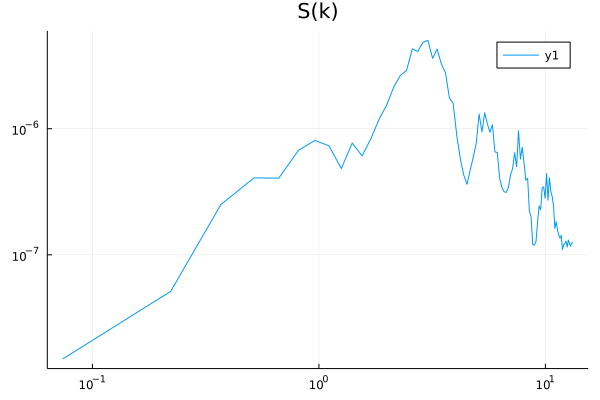

In [ ]:
p3 = plot(k_list[1],mm,xscale=:log10, yscale=:log10,title="S(k)")


In [ ]:
k_list[1]

90-element Vector{Float64}:
  0.07387444743227807
  0.22162334229683422
  0.36937223716139034
  0.5171211320259466
  0.6648700268905027
  0.8126189217550588
  0.960367816619615
  1.108116711484171
  1.2558656063487272
  1.4036145012132835
  1.5513633960778395
  1.6991122909423957
  1.846861185806952
  ⋮
 11.598288246867657
 11.746037141732213
 11.893786036596769
 12.041534931461324
 12.189283826325882
 12.337032721190438
 12.484781616054994
 12.63253051091955
 12.780279405784105
 12.928028300648663
 13.075777195513218
 13.223526090377774

In [ ]:
mm

90-element Vector{Float64}:
 1.4926944208722776e-8
 5.1329051682068446e-8
 2.507392713419593e-7
 4.074691430140011e-7
 4.0532835036935945e-7
 6.737387453599649e-7
 8.066136712789552e-7
 7.322809588116968e-7
 4.831654738682656e-7
 7.691583292332905e-7
 6.089838597314972e-7
 8.387417019524145e-7
 1.1962001834832895e-6
 ⋮
 1.3562963509873202e-7
 1.425273572422858e-7
 1.100666752360377e-7
 1.2078244323766622e-7
 1.2258380123711803e-7
 1.2863179363706145e-7
 1.1528814229698757e-7
 1.310761456321709e-7
 1.2136725833963362e-7
 1.1721209953637132e-7
 1.2464930923582218e-7
 1.2496462917144356e-7

In [ ]:
# plot the struture factor
p2 = heatmap(kx_list[1],ky_list[1],log10.(s_2d[1])',aspect_ratio=:equal,tellheight=true,interpolate=true,title="log10 S(kx,ky)")
xlims!(p2,kx_list[1],kx[end])
ylims!(p2,kx_list[1],ky[end])

LoadError: Cannot convert Float64 to series data for plotting

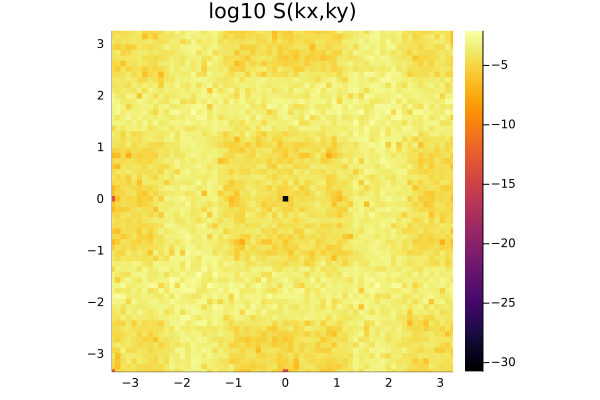

In [8]:
include("./src/utils.jl")

kx,ky,s_2d = get_structure_factor(reshape(model.rho,nx,ny),nx,ny,x_max,y_max)
# kx,ky,s_2d = get_structure_factor(reshape(randn(model.npts[1]*model.npts[2]), (model.npts[1],model.npts[2])),nx,ny,x_max,y_max)

# plot the struture factor
p2 = heatmap(kx,ky,log10.(s_2d)',aspect_ratio=:equal,tellheight=true,interpolate=true,title="log10 S(kx,ky)")
xlims!(p2,kx[1],kx[end])
ylims!(p2,kx[1],ky[end])


┌ Warning: Skipped marker arg o.
└ @ Plots /Users/satyamanand/.julia/packages/Plots/Di0Qb/src/args.jl:1189


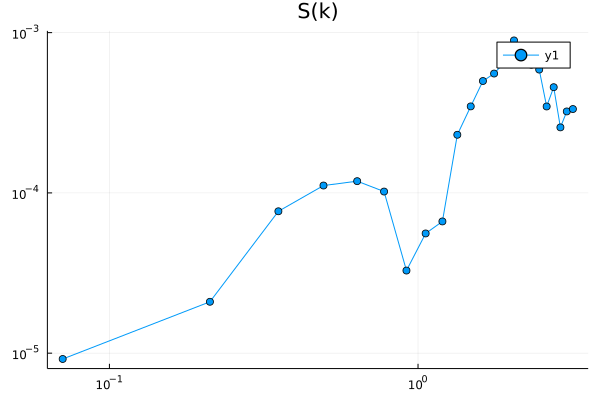

In [9]:
#plot the radial structure factor
k,s = get_radial_structure_factor(kx,ky,s_2d)
p3 = plot(k,s, marker='o', xscale=:log10, yscale=:log10,title="S(k)")
# p3 = plot(k,s,title="S(k)")



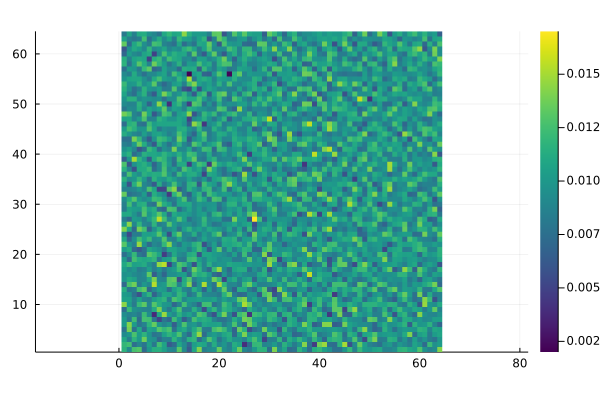

In [10]:
heatmap(reshape(rho_final,nx,ny), color=:viridis, aspect_ratio=:equal)

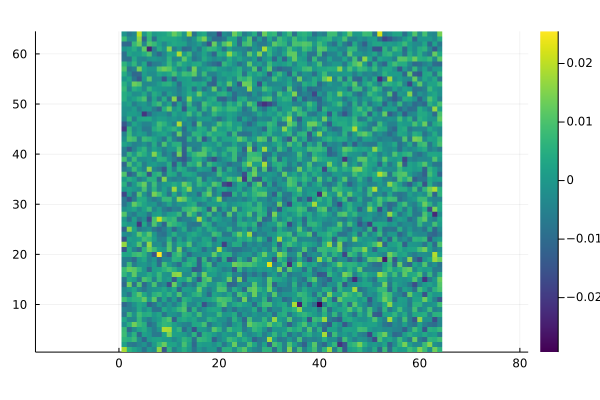

In [11]:
heatmap(model.color_noise[(2,)], color=:viridis, aspect_ratio=:equal)

In [ ]:
model.noise_kernel[(2,2)]

7×7 Matrix{Float64}:
 0.0  0.0     0.0       0.0  0.0       0.0     0.0
 0.0  0.0     0.0       0.0  0.0       0.0     0.0
 0.0  0.0     0.331456  0.0  0.331456  0.0     0.0
 0.0  0.9375  0.46875   0.0  0.46875   0.9375  0.0
 0.0  0.0     0.331456  0.0  0.331456  0.0     0.0
 0.0  0.0     0.0       0.0  0.0       0.0     0.0
 0.0  0.0     0.0       0.0  0.0       0.0     0.0

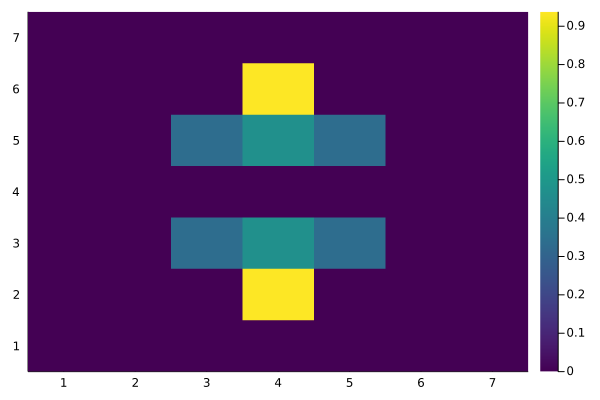

In [ ]:
heatmap(model.noise_kernel[(2,2)]', color=:viridis)

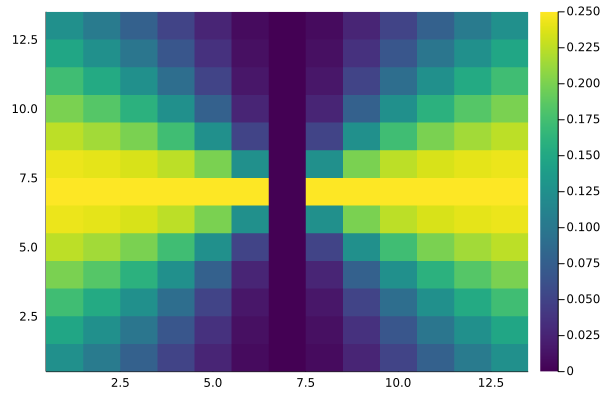

In [ ]:
heatmap(model.stress_kernel[(2,2)], color=:viridis)

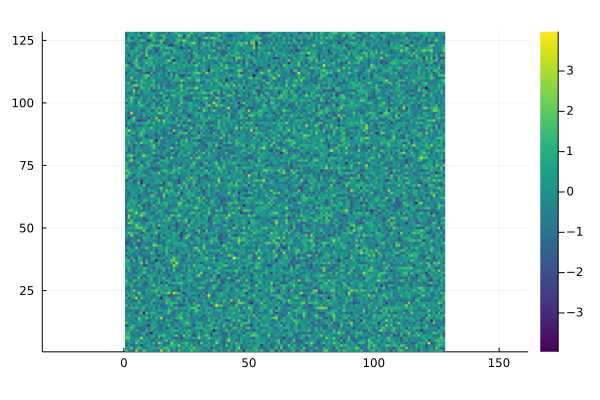

In [ ]:
heatmap(reshape(randn(model.npts[1]*model.npts[2]), (model.npts[1],model.npts[2])), color=:viridis, aspect_ratio=:equal)